# Task 2

---

## Predictive modeling of customer bookings

This Jupyter notebook includes some code to get you started with this predictive modeling task. We will use various packages for data manipulation, feature engineering and machine learning.

### Exploratory data analysis

First, we must explore the data in order to better understand what we have and the statistical properties of the dataset.

In [ ]:
pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.linear_model import LogisticRegressionCV
import matplotlib.pyplot as plt
import seaborn as sns
from category_encoders import TargetEncoder
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

In [ ]:
df = pd.read_csv("customer_booking.csv", encoding="ISO-8859-1")
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


The `.head()` method allows us to view the first 5 rows in the dataset, this is useful for visual inspection of our columns

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

The `.info()` method gives us a data description, telling us the names of the columns, their data types and how many null values we have. Fortunately, we have no null values. It looks like some of these columns should be converted into different data types, e.g. flight_day.

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

Before we compute any statistics on the data, lets do any necessary data conversion

In [ ]:
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,1.000000,1.000000,1.000000,9.500000,1.000000


In [ ]:
df['booking_complete'].value_counts()

booking_complete
0    42522
1     7478
Name: count, dtype: int64

In [ ]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

# Apply the mapping
df["flight_day"] = df["flight_day"].map(mapping)

# Create is_weekend feature
df['is_weekend'] = df['flight_day'].apply(lambda x: 1 if x in [6, 7] else 0)

In [ ]:
df.isna().sum()

num_passengers           0
sales_channel            0
trip_type                0
purchase_lead            0
length_of_stay           0
flight_hour              0
flight_day               0
route                    0
booking_origin           0
wants_extra_baggage      0
wants_preferred_seat     0
wants_in_flight_meals    0
flight_duration          0
booking_complete         0
is_weekend               0
dtype: int64

In [ ]:
df.duplicated().sum()

719

In [ ]:
df.drop_duplicates(inplace=True)

In [ ]:
df.shape

(49281, 15)

In [ ]:
num_cols = df.select_dtypes(include=['number']).columns

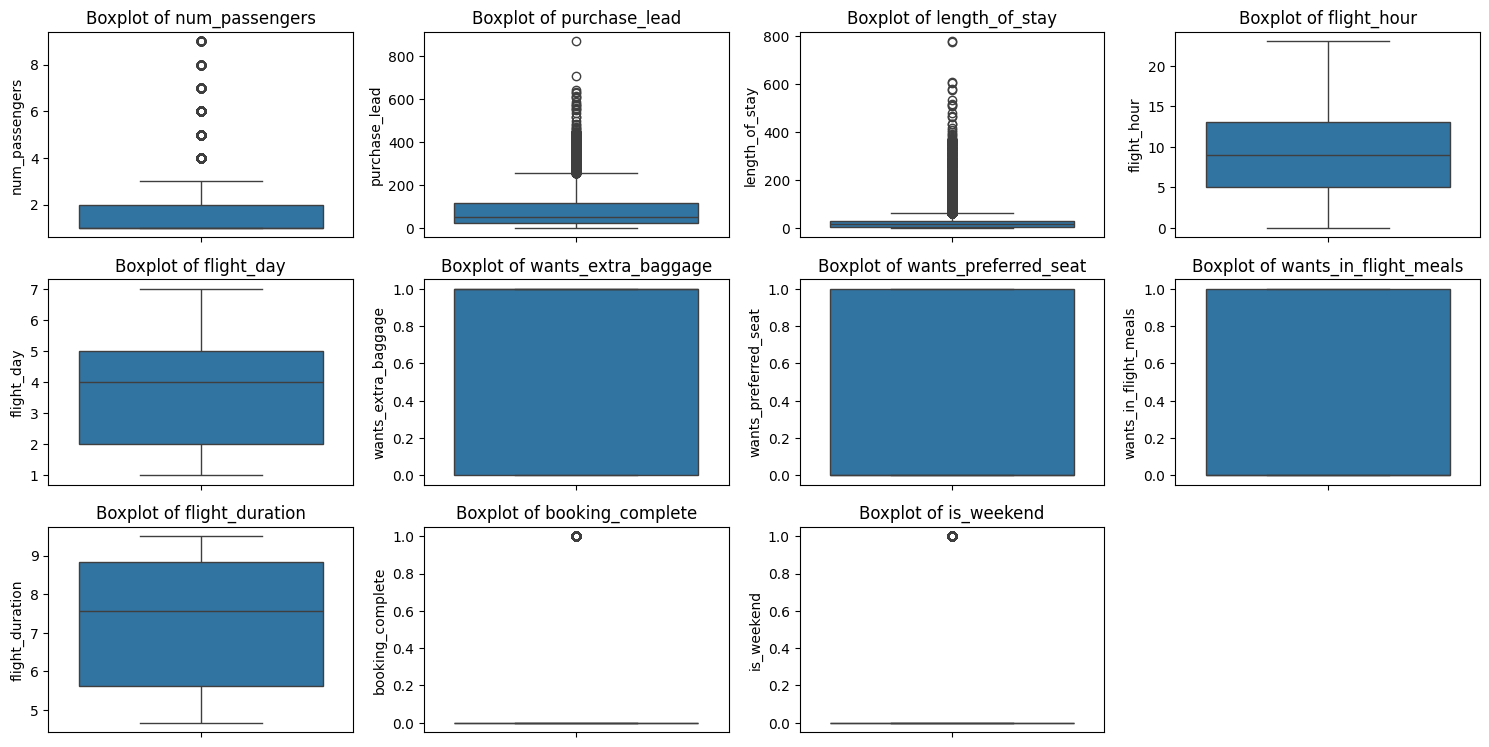

In [ ]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(num_cols, 1):
    plt.subplot(4, 4, i)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

In [ ]:
def cap_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    return df

In [ ]:
check_outlier = ['num_passengers', 'purchase_lead', 'length_of_stay', 'flight_hour',
       'flight_day', 'wants_extra_baggage', 'wants_preferred_seat',
       'wants_in_flight_meals', 'flight_duration']

In [ ]:
for col in check_outlier :
    df = cap_outliers(df, col)

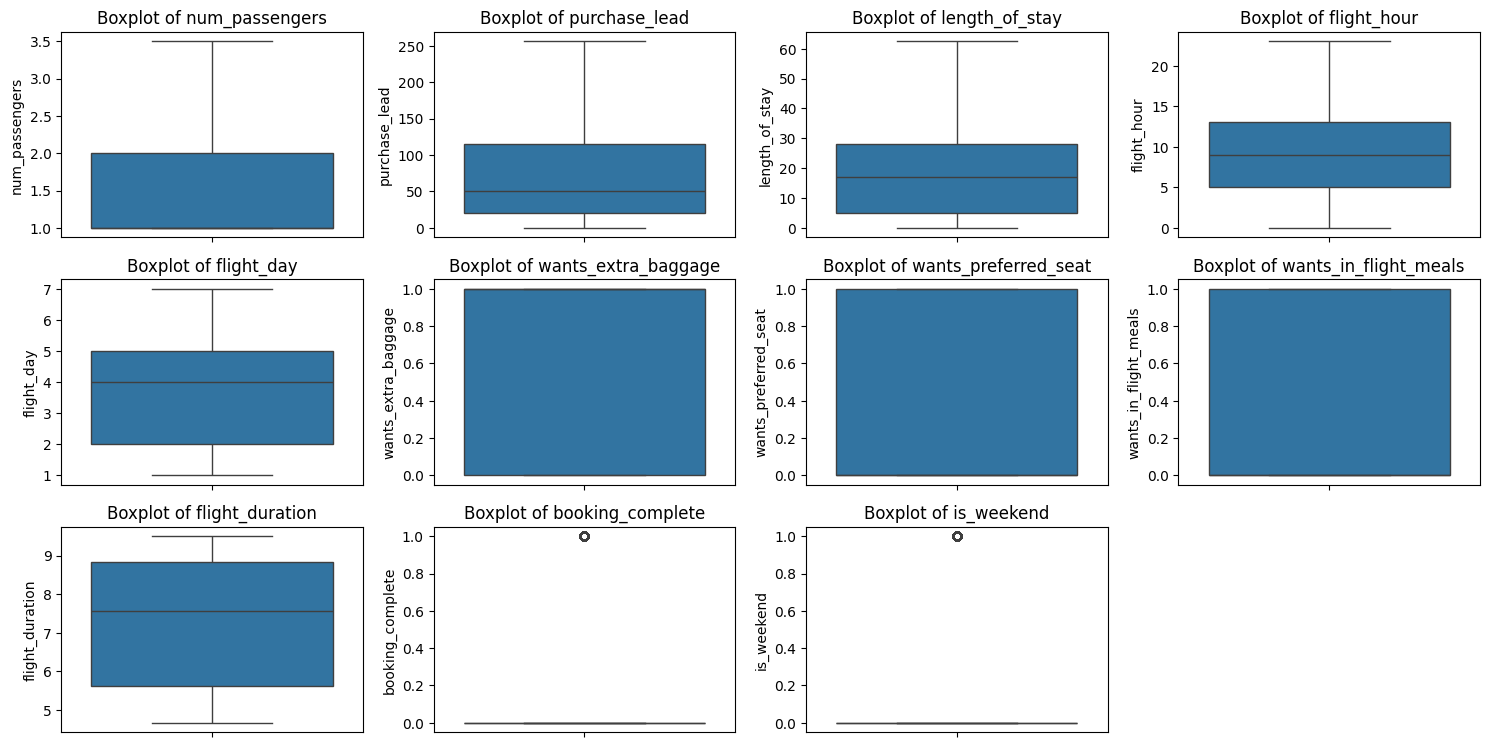

In [ ]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(num_cols, 1):
    plt.subplot(4, 4, i)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

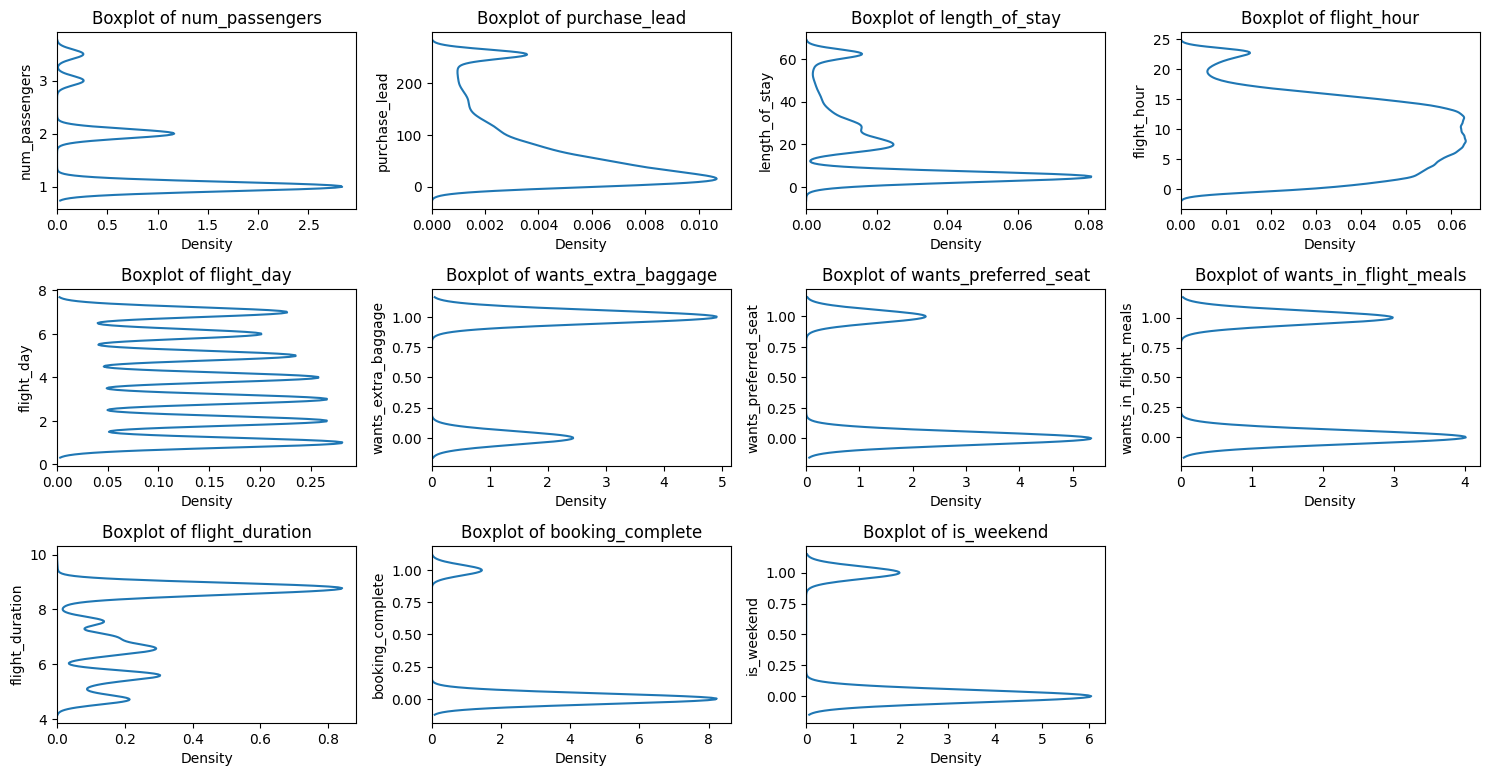

In [ ]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(num_cols, 1):
    plt.subplot(4, 4, i)
    sns.kdeplot(y=df[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

In [ ]:
weekend= df.groupby('is_weekend')['num_passengers'].sum().reset_index()

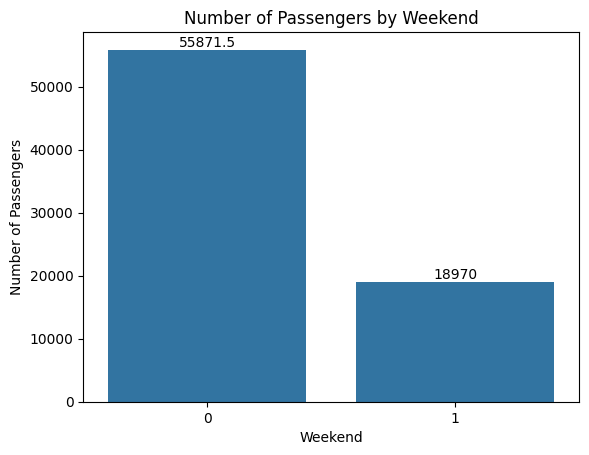

In [ ]:
ax = sns.barplot(x='is_weekend', y='num_passengers', data=weekend)
ax.bar_label(ax.containers[0])
plt.title('Number of Passengers by Weekend')
plt.xlabel('Weekend')
plt.ylabel('Number of Passengers')
plt.show()

In [ ]:
num_cust_per_day = df.groupby('flight_day')['num_passengers'].mean().reset_index()


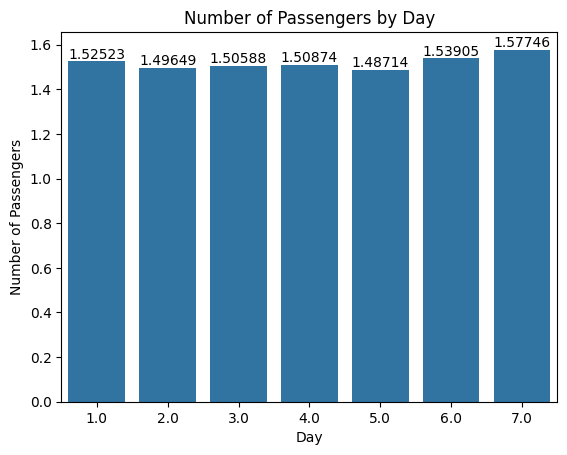

In [ ]:
ax = sns.barplot(x='flight_day', y='num_passengers', data=num_cust_per_day)
ax.bar_label(ax.containers[0])
plt.title('Number of Passengers by Day')
plt.xlabel('Day')
plt.ylabel('Number of Passengers')
plt.show();

In [ ]:
df.nunique()

num_passengers             4
sales_channel              2
trip_type                  3
purchase_lead            257
length_of_stay            54
flight_hour               24
flight_day                 7
route                    799
booking_origin           104
wants_extra_baggage        2
wants_preferred_seat       2
wants_in_flight_meals      2
flight_duration           21
booking_complete           2
is_weekend                 2
dtype: int64

In [ ]:
X = df.drop('booking_complete', axis=1)
y = df['booking_complete']


In [ ]:

categorical_columns = X.select_dtypes(include=['object']).columns
target_encoded_cols = ['booking_origin', 'route']
exclude_cols = ['booking_complete']
num_cols_filtered = [col for col in num_cols if col not in exclude_cols]

In [ ]:
categorical_columns

Index(['sales_channel', 'trip_type', 'route', 'booking_origin'], dtype='object')

# **Logistic Regression**

In [ ]:
X = df.drop('booking_complete', axis=1)
y = df['booking_complete']

In [ ]:
X

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,is_weekend
0,2.0,Internet,RoundTrip,256.0,19.0,7.0,6.0,AKLDEL,New Zealand,1.0,0.0,0.0,5.52,1
1,1.0,Internet,RoundTrip,112.0,20.0,3.0,6.0,AKLDEL,New Zealand,0.0,0.0,0.0,5.52,1
2,2.0,Internet,RoundTrip,243.0,22.0,17.0,3.0,AKLDEL,India,1.0,1.0,0.0,5.52,0
3,1.0,Internet,RoundTrip,96.0,31.0,4.0,6.0,AKLDEL,New Zealand,0.0,0.0,1.0,5.52,1
4,2.0,Internet,RoundTrip,68.0,22.0,15.0,3.0,AKLDEL,India,1.0,0.0,1.0,5.52,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,2.0,Internet,RoundTrip,27.0,6.0,9.0,6.0,PERPNH,Australia,1.0,0.0,1.0,5.62,1
49996,1.0,Internet,RoundTrip,111.0,6.0,4.0,7.0,PERPNH,Australia,0.0,0.0,0.0,5.62,1
49997,1.0,Internet,RoundTrip,24.0,6.0,22.0,6.0,PERPNH,Australia,0.0,0.0,1.0,5.62,1
49998,1.0,Internet,RoundTrip,15.0,6.0,11.0,1.0,PERPNH,Australia,1.0,0.0,1.0,5.62,0


In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,stratify=y)

In [ ]:


# Identify features
target_column = 'booking_complete'
target_encode_features = ['booking_origin', 'route']
one_hot_encode_features = ['sales_channel', 'trip_type']

# Identify numerical features after splitting
numerical_features = [col for col in X_train.columns if X_train[col].dtype in ['int64', 'float64']]

# Apply Target Encoding
target_encoder = TargetEncoder(cols=target_encode_features)
X_train[target_encode_features] = target_encoder.fit_transform(X_train[target_encode_features], y_train)
X_test[target_encode_features] = target_encoder.transform(X_test[target_encode_features])

# Apply One-Hot Encoding
one_hot_encoder = OneHotEncoder(sparse=False, drop='first')  # drop='first' to avoid dummy variable trap
X_train_one_hot = one_hot_encoder.fit_transform(X_train[one_hot_encode_features])
X_test_one_hot = one_hot_encoder.transform(X_test[one_hot_encode_features])

# Convert one-hot encoded arrays back to DataFrames
X_train_one_hot_df = pd.DataFrame(X_train_one_hot, columns=one_hot_encoder.get_feature_names_out(one_hot_encode_features))
X_test_one_hot_df = pd.DataFrame(X_test_one_hot, columns=one_hot_encoder.get_feature_names_out(one_hot_encode_features))

# Reset indices to match the main DataFrames
X_train_one_hot_df.index = X_train.index
X_test_one_hot_df.index = X_test.index

# Drop original one-hot encoded features and add the new one-hot encoded columns
X_train = X_train.drop(columns=one_hot_encode_features)
X_test = X_test.drop(columns=one_hot_encode_features)
X_train = pd.concat([X_train, X_train_one_hot_df], axis=1)
X_test = pd.concat([X_test, X_test_one_hot_df], axis=1)

# Oversample the training set using SMote
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Apply Standard Scaling to numerical features
scaler = StandardScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])




/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [80]:
# Define and fit the model
model = LogisticRegressionCV(
    cv=5,
    penalty='elasticnet',
    solver='saga',
    l1_ratios=[.1, .5, .7, .9, .95, .99, 1],
    scoring='recall',
    max_iter=100,
    random_state=42
)

model.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
classification_report_str = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Classification Report:\n", classification_report_str)

Accuracy: 0.723706459249239
F1 Score: 0.4156772993849235
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.74      0.82     12568
           1       0.30      0.66      0.42      2217

    accuracy                           0.72     14785
   macro avg       0.61      0.70      0.62     14785
weighted avg       0.83      0.72      0.76     14785



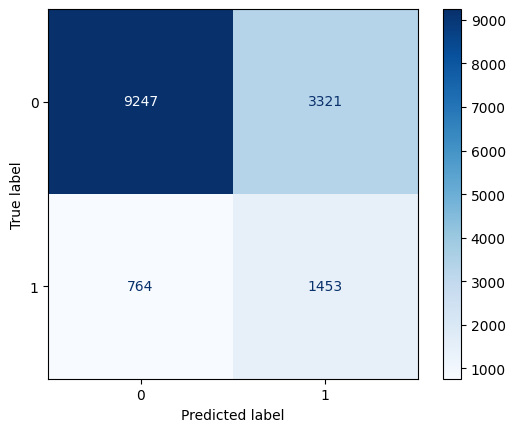

In [81]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Display confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap='Blues')

In [46]:
# Define a reduced parameter grid
param_grid = {
    'n_estimators': [50, 100],  # Fewer options for n_estimators
    'max_depth': [10, 20],  # Two options for max_depth
    'min_samples_split': [2, 10],  # Two options for min_samples_split
    'min_samples_leaf': [1, 4],  # Two options for min_samples_leaf
    'max_features': ['sqrt', 'log2']  # Two options for max_features
}

In [47]:
# Initialize Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid,
                           cv=5, scoring='recall', verbose=1, n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best model
best_rf_model = grid_search.best_estimator_

# Predict on test set
y_pred = best_rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
classification_report_str = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# Print evaluation metrics and confusion matrix
print("Best Parameters:", grid_search.best_params_)
print("\nAccuracy:", accuracy)
print("F1 Score:", f1)
print("Classification Report:\n", classification_report_str)
print("Confusion Matrix:\n", cm)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}

Accuracy: 0.8029759891782212
F1 Score: 0.404902962206333
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.87      0.88     12568
           1       0.37      0.45      0.40      2217

    accuracy                           0.80     14785
   macro avg       0.63      0.66      0.64     14785
weighted avg       0.82      0.80      0.81     14785

Confusion Matrix:
 [[10881  1687]
 [ 1226   991]]


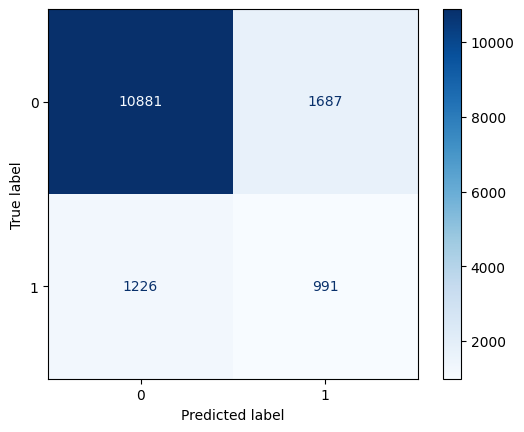

In [48]:
# Display confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_rf_model.classes_)
disp.plot(cmap='Blues')

In [77]:
lr_importance = np.abs(model.coef_[0])  # Use the absolute value of coefficients
lr_features = pd.DataFrame({'Feature': X_train.columns, 'Importance': lr_importance})


In [53]:
# Get feature importances for Random Forest
rf_importance = best_rf_model.feature_importances_
rf_features = pd.DataFrame({'Feature': X_train.columns, 'Importance': rf_importance})


In [78]:
# Sort features by importance
lr_features = lr_features.sort_values(by='Importance', ascending=False)
rf_features = rf_features.sort_values(by='Importance', ascending=False)

<ipython-input-79-bef051da83b4>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=lr_features, palette='viridis')


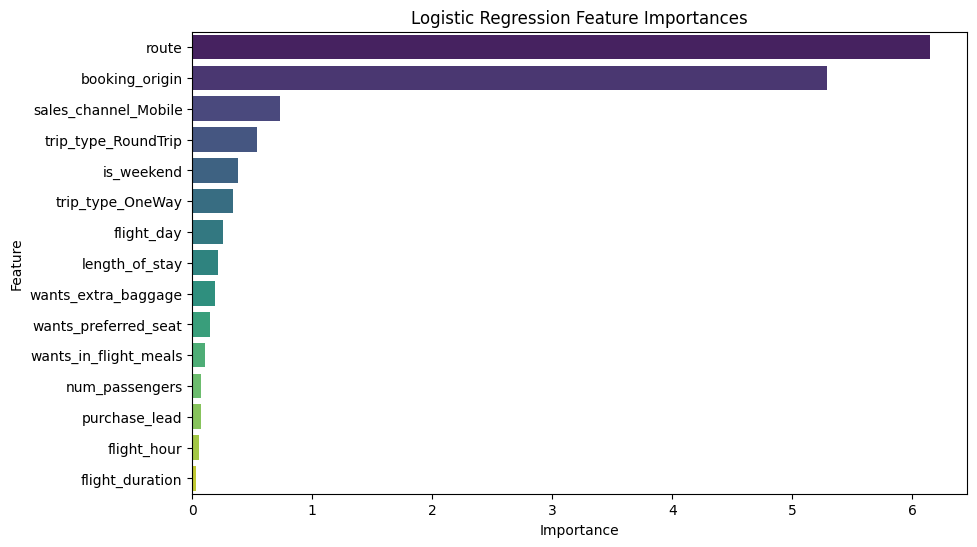

In [79]:
# Plot Logistic Regression feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=lr_features, palette='viridis')
plt.title('Logistic Regression Feature Importances')
plt.show();

<ipython-input-58-0563d24b8c65>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=rf_features, palette='viridis')


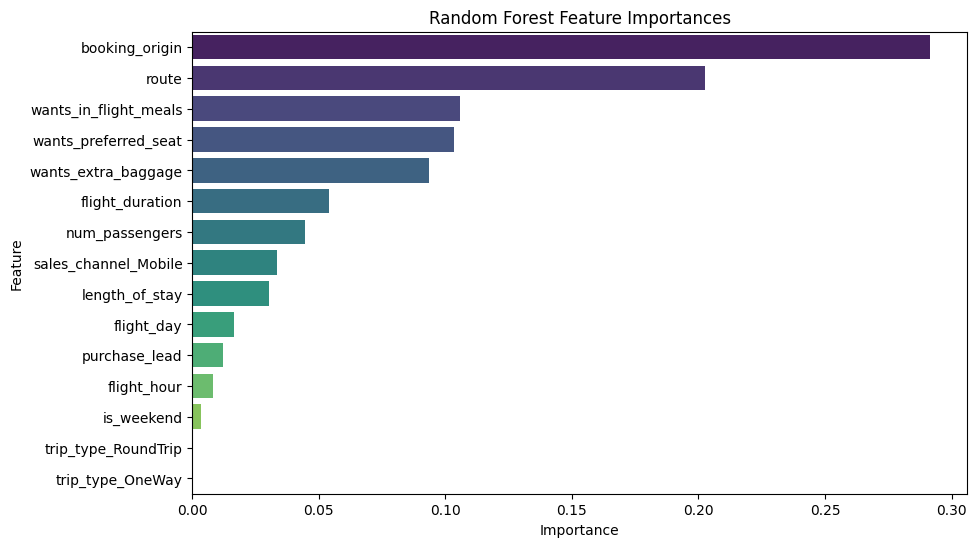

In [58]:
# Plot Random Forest feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=rf_features, palette='viridis')
plt.title('Random Forest Feature Importances')
plt.show()

In [59]:
# Identify top 4 features from both models
top_4_lr_features = lr_features['Feature'].head(4).tolist()
top_4_rf_features = rf_features['Feature'].head(4).tolist()


In [60]:
# Subset the training and testing data to include only the top 4 features
X_train_lr_top4 = X_train[top_4_lr_features]
X_test_lr_top4 = X_test[top_4_lr_features]

X_train_rf_top4 = X_train[top_4_rf_features]
X_test_rf_top4 = X_test[top_4_rf_features]

In [72]:
# Train and evaluate Logistic Regression model with top 4 features
lr_model_top4 = LogisticRegressionCV(cv=5, penalty='l2', solver='saga', l1_ratios=[.1, .5, .7, .9, .95, .99, 1],
                                     scoring='recall', max_iter=100, random_state=42 )
lr_model_top4.fit(X_train_lr_top4, y_train)

y_pred_lr_top4 = lr_model_top4.predict(X_test_lr_top4)

accuracy_lr_top4 = accuracy_score(y_test, y_pred_lr_top4)
f1_lr_top4 = f1_score(y_test, y_pred_lr_top4, average='weighted')
classification_report_lr_top4 = classification_report(y_test, y_pred_lr_top4)

print("Logistic Regression with Top 4 Features")
print("Accuracy:", accuracy_lr_top4)
print("F1 Score:", f1_lr_top4)
print("Classification Report:\n", classification_report_lr_top4)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1785: UserWarning: l1_ratios parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


Logistic Regression with Top 4 Features
Accuracy: 0.7187690226580994
F1 Score: 0.7552207284196722
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.73      0.81     12568
           1       0.30      0.68      0.42      2217

    accuracy                           0.72     14785
   macro avg       0.62      0.70      0.62     14785
weighted avg       0.83      0.72      0.76     14785



In [73]:
cm_lr_top4 = confusion_matrix(y_test, y_pred_lr_top4)

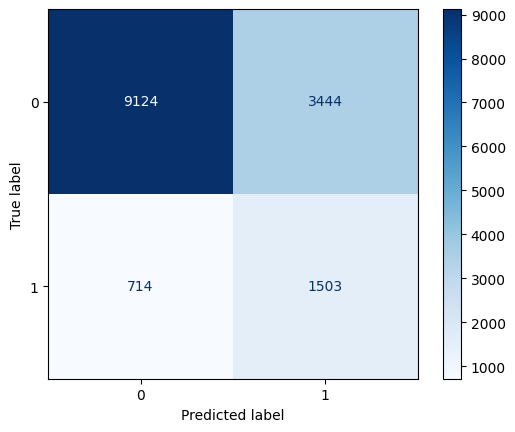

In [74]:
# Display confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm_lr_top4, display_labels=lr_model_top4.classes_)
disp.plot(cmap='Blues')

In [67]:
rf_model_top4 = RandomForestClassifier(random_state=42)

grid_search_rf = GridSearchCV(estimator=rf_model_top4, param_grid=param_grid, cv=5, scoring='recall', verbose=1, n_jobs=-1)
grid_search_rf.fit(X_train_rf_top4, y_train)

best_rf_model_top4 = grid_search_rf.best_estimator_

y_pred_rf_top4 = best_rf_model_top4.predict(X_test_rf_top4)

accuracy_rf_top4 = accuracy_score(y_test, y_pred_rf_top4)
f1_rf_top4 = f1_score(y_test, y_pred_rf_top4, average='weighted')
classification_report_rf_top4 = classification_report(y_test, y_pred_rf_top4)

print("Random Forest with Top 4 Features")
print("Best Parameters:", grid_search_rf.best_params_)
print("Accuracy:", accuracy_rf_top4)
print("F1 Score:", f1_rf_top4)
print("Classification Report:\n", classification_report_rf_top4)


Fitting 5 folds for each of 32 candidates, totalling 160 fits
Random Forest with Top 4 Features
Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 50}
Accuracy: 0.791680757524518
F1 Score: 0.7960250239953361
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.87      0.88     12568
           1       0.32      0.36      0.34      2217

    accuracy                           0.79     14785
   macro avg       0.60      0.61      0.61     14785
weighted avg       0.80      0.79      0.80     14785



In [68]:
cm_rf_top4 = confusion_matrix(y_test, y_pred_rf_top4)

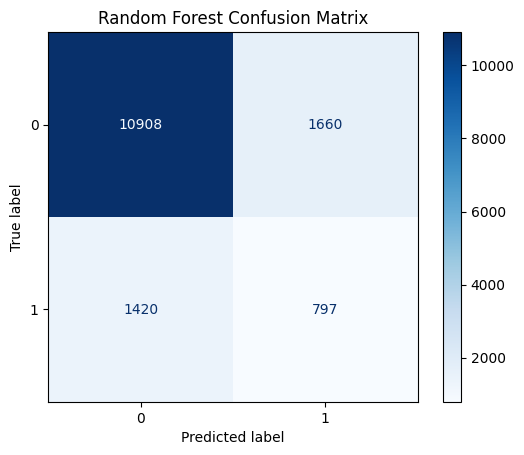

In [69]:
# Display confusion matrix for Random Forest using ConfusionMatrixDisplay
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf_top4, display_labels=best_rf_model_top4.classes_)
disp_rf.plot(cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.show()